In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yaml
import librosa
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import IPython.display as ipd

from lava.lib.dl import slayer
from audio_dataloader import DNSAudio
from snr import si_snr
from dnsmos import DNSMOS

import h5py

In [2]:
import pdb

In [3]:
from train_nas_fullconv_baseline import collate_fn, stft_splitter, stft_mixer, nop_stats, Network

In [4]:
trained_folder = '../20230707_loh_nas_runs'
args = yaml.safe_load(open(trained_folder + '/args.txt', 'rt'))
if 'out_delay' not in args.keys():
    args['out_delay'] = 0
if 'n_fft' not in args.keys():
    args['n_fft'] = 512
device = torch.device('cpu') #torch.device('cuda:0')
root = '/mnt/data4tb/stadtmann/dns_challenge_4/datasets_fullband/' #args['path']
out_delay = args['out_delay']
n_fft = args['n_fft']
win_length = n_fft
hop_length = n_fft // 4
stats = slayer.utils.LearningStats(accuracy_str='SI-SNR', accuracy_unit='dB')

In [5]:
train_set = DNSAudio(root=root + 'training_set/')
validation_set = DNSAudio(root=root + 'validation_set/')

train_loader = DataLoader(train_set,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=4,
                          pin_memory=True)
validation_loader = DataLoader(validation_set,
                               batch_size=32,
                               shuffle=True,
                               collate_fn=collate_fn,
                               num_workers=4,
                               pin_memory=True)

In [6]:
kk = 5
cc = 256
dd = 5

net = Network(kk,cc,dd,
                args['threshold'],
                args['tau_grad'],
                args['scale_grad'],
                args['dmax'],
                args['out_delay']).to(device)

In [7]:
# register hooks for activation
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for ii, l in enumerate(net.blocks):
    l.register_forward_hook(get_activation('net'+ str(ii)))

In [8]:
debug_sample_no = 0

In [9]:
noisy, clean, noise, metadata = train_set[debug_sample_no]
noisy = torch.unsqueeze(torch.FloatTensor(noisy), dim=0).to(device)
noisy_abs, noisy_arg = stft_splitter(noisy, n_fft)
net(noisy_abs.to(device))
net.load_state_dict(torch.load(trained_folder + '/trained_k5c256d5_optfcn_Adamlr_customschedule' + '/network.pt',map_location=device))
net.eval()

Network(
  (blocks): ModuleList(
    (0): Conv1d(257, 256, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [10]:
denoised_abs = net(noisy_abs)
cleaned = stft_mixer(denoised_abs, noisy_arg, n_fft)

# wavio.write("debug_in.wav", noisy.squeeze(0).detach(),16000,sampwidth=2)
# wavio.write("debug_out.wav", cleaned.squeeze(0).detach(),16000,sampwidth=2)
# wavio.write("debug_ref.wav", clean,16000,sampwidth=2)

In [11]:
ipd.Audio(noisy.squeeze(0).detach(), rate=16000)

In [12]:
ipd.Audio(cleaned.squeeze(0).detach(), rate=16000)

In [13]:
ipd.Audio(clean, rate=16000)

In [14]:
# test = net(noisy_abs)
# test.shape

In [15]:
# def merge_conv_bn(lconv,lbn):

#     lconv_out = torch.nn.Conv1d(lconv.weight.shape[1],
#                                 lconv.weight.shape[0],
#                                 kernel_size=lconv.weight.shape[2],
#                                 padding='same',
#                                 bias=False)

#     #pdb.set_trace()

#     lconv_out.weight = torch.nn.Parameter(
#         lconv.weight * 
#         torch.reshape(lbn.weight.repeat_interleave(torch.prod(torch.tensor(list(lconv.weight.shape[1:])))),lconv.weight.shape) / 
#         torch.sqrt(torch.reshape(lbn.running_var.repeat_interleave(torch.prod(torch.tensor(list(lconv.weight.shape[1:])))),lconv.weight.shape))
#         , requires_grad=False)

#     lconv_out.bias = torch.nn.Parameter(torch.zeros(lbn.bias.shape),requires_grad=False)
        
#     if lconv.bias == None:
#         lconvbias = torch.zeros(lbn.bias.shape)
#     else:
#         lconvbias = lconv.bias

#     lconv_out.bias = torch.nn.Parameter(
#         ((lconvbias-lbn.running_mean)*lbn.weight) 
#         / torch.sqrt(lbn.running_var) 
#         + lbn.bias
#         ,requires_grad=False)

#     return lconv_out

In [16]:
# snn_layer_conv_list = []
# snn_layer_res_list = []

# for pt_layer in net.blocks:
#     if not(isinstance(pt_layer, torch.nn.ReLU)):
#         snn_layer_conv_list.append(pt_layer)
#     else:
#         #snn_layer_conv_list.append(pt_layer)
#         #pdb.set_trace()
        
#         lconv = merge_conv_bn(snn_layer_conv_list[0],snn_layer_conv_list[1])
#         snn_layer_res_list.append(lconv)
#         snn_layer_res_list.append(pt_layer)
#         snn_layer_conv_list = []



In [17]:
# x= noisy_abs

# for block in snn_layer_res_list:
#     x = block(x)
#     print(x)

In [18]:
class SNNConverted(torch.nn.Module):
    def __init__(self, net):
        super().__init__()

        snn_merged_layers = self.net_merge_conv_bn(net)
        self.blocks_merged = torch.nn.ModuleList(snn_merged_layers)

        self.blocks_normed = self.blocks_merged
        self.lmbda = torch.tensor([0.0027, 0.0150, 0.0146, 0.0101, 0.0065, 0.0024, 0.0016, 0.0261])
        self.dlta = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0.])
        self.lup = torch.tensor([370.1278,  66.8139,  68.3386,  99.2883, 155.0141, 413.0635, 642.4062,
         38.3423])
        self.ldown = torch.tensor([    0.0000,  -125.7344,   -82.8624,   -59.2139,   -55.1802,  -117.6727,
         -695.0682, -1016.6787])
        self.update_normed()
        
        self.blocks_snn = []

        self.input_quantizer = lambda x: slayer.utils.quantize(x, step=1 / 64)

    def forward(self, noisy):
        x = noisy
        for block in self.blocks:
            x = block(x)

        return x

    def update_normed(self):
        snn_normed_layers = self.net_norm_layers(self.blocks_merged)
        self.blocks_normed = torch.nn.ModuleList(snn_normed_layers)
        return
    
    def net_norm_layers(self,net):
        snn_layer_res_list = []
        ii=0

        for pt_layer in net:
            if not(isinstance(pt_layer, torch.nn.Conv1d)):
                snn_layer_res_list.append(pt_layer)
            else:
                lconv = torch.nn.Conv1d(pt_layer.weight.shape[1],
                                        pt_layer.weight.shape[0],
                                        kernel_size=pt_layer.weight.shape[2],
                                        padding='same',
                                        bias=False)
                
                lconv.weight = torch.nn.Parameter(
                    pt_layer.weight * (self.lmbda[ii+1]/self.lmbda[ii])
                    ,requires_grad=False
                )

                #pdb.set_trace()
                lconv.bias = torch.nn.Parameter(
                    (pt_layer.bias - torch.sum(pt_layer.weight * (self.dlta[ii]/self.lmbda[ii]),dim=(1,2)))
                     * self.lmbda[ii+1]
                    ,requires_grad=False
                )
                snn_layer_res_list.append(lconv)
                ii=ii+1

        return snn_layer_res_list

    def net_merge_conv_bn(self,net):
        snn_layer_conv_list = []
        snn_layer_res_list = []

        for pt_layer in net.blocks:
            if not(isinstance(pt_layer, torch.nn.ReLU)):
                snn_layer_conv_list.append(pt_layer)
            else:
                lconv = self.merge_conv_bn(snn_layer_conv_list[0],snn_layer_conv_list[1])
                snn_layer_res_list.append(lconv)
                snn_layer_res_list.append(pt_layer)
                snn_layer_conv_list = []

        return snn_layer_res_list

    def merge_conv_bn(self,lconv,lbn):
        lconv_out = torch.nn.Conv1d(lconv.weight.shape[1],
                                    lconv.weight.shape[0],
                                    kernel_size=lconv.weight.shape[2],
                                    padding='same',
                                    bias=False)


        lconv_out.weight = torch.nn.Parameter(
            lconv.weight * 
            torch.reshape(lbn.weight.repeat_interleave(torch.prod(torch.tensor(list(lconv.weight.shape[1:])))),lconv.weight.shape) / 
            torch.sqrt(torch.reshape(lbn.running_var.repeat_interleave(torch.prod(torch.tensor(list(lconv.weight.shape[1:])))),lconv.weight.shape))
            , requires_grad=False)
            
        if lconv.bias == None:
            lconvbias = torch.zeros(lbn.bias.shape)
        else:
            lconvbias = lconv.bias

        lconv_out.bias = torch.nn.Parameter(
            ((lconvbias-lbn.running_mean)*lbn.weight) 
            / torch.sqrt(lbn.running_var) 
            + lbn.bias
            ,requires_grad=False)

        return lconv_out

    def calc_norm_factors(self,train_loader):
        no_factors = len([1 for m in self.blocks_merged if isinstance(m,torch.nn.Conv1d)]) + 1
        self.lmbda = torch.Tensor([1] * no_factors)
        self.dlta = torch.Tensor([0] * no_factors)
        self.lup = torch.Tensor([-float("inf")] * no_factors)
        self.ldown = torch.Tensor([float("inf")] * no_factors)

        for i, (noisy, clean, noise) in enumerate(train_loader):
            with torch.no_grad():
                noisy = noisy.to(device)
                #clean = clean.to(device)

                x, noisy_arg = stft_splitter(noisy, n_fft)
                #clean_abs, clean_arg = stft_splitter(clean, n_fft)

                #denoised_abs, count = net(noisy_abs)
                #denoised_abs = net(noisy_abs)

                #pdb.set_trace()

                self.lup[0] = torch.max(self.lup[0], torch.max(x))
                self.ldown[0] = torch.min(self.ldown[0], torch.min(x))

                
                self.lmbda[0] = 1/self.lup[0]
                self.dlta[0] = 0
                ii=0

                for block in self.blocks_merged:
                    x = block(x)
                    
                    if isinstance(block,torch.nn.Conv1d):
                        self.lup[ii+1] = torch.max(self.lup[ii+1], torch.max(x))
                        self.ldown[ii+1] = torch.min(self.ldown[ii+1], torch.min(x))

                        self.lmbda[ii+1] = 1/self.lup[ii+1]
                        self.dlta[ii+1] = 0

                        ii=ii+1
                

                print(self.lup)
                print(self.ldown)
                print(self.lmbda)
                print(self.dlta)  
        return

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [19]:
snet = SNNConverted(net)

In [20]:
snet

SNNConverted(
  (blocks_merged): ModuleList(
    (0): Conv1d(257, 256, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU(inplace=True)
    (4): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (5): ReLU(inplace=True)
    (6): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (7): ReLU(inplace=True)
    (8): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (9): ReLU(inplace=True)
    (10): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (11): ReLU(inplace=True)
    (12): Conv1d(256, 257, kernel_size=(5,), stride=(1,), padding=same)
    (13): ReLU(inplace=True)
  )
  (blocks_normed): ModuleList(
    (0): Conv1d(257, 256, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU(inplace=True)
    (4): Conv1d(256, 256,

In [21]:
# snet.calc_norm_factors(train_loader)

In [22]:
# print(snet.lup)
# print(snet.ldown)
# print(snet.lmbda)
# print(snet.dlta)

In [23]:
x= noisy_abs

for block in net.blocks:
    x = block(x)
    print(x)

tensor([[[ 58.0818,  43.1790,  16.7752,  ..., -18.6377, -20.7545,  -8.9385],
         [ -3.9119,  -4.5315,   5.6619,  ..., -61.4095, -60.6615, -40.7283],
         [ -5.0677,   1.1586,  -2.0385,  ..., -13.2587,  -5.6754,  12.3676],
         ...,
         [ 21.0297,  24.2034,  31.7955,  ...,   7.2986,  16.2699,  21.6688],
         [  4.1784,  10.9946,   7.9170,  ...,   2.2013, -10.8438,  -4.1442],
         [-17.7023, -21.5482,  -7.5608,  ...,  15.7587,  10.7845,  -7.9970]]],
       grad_fn=<ConvolutionBackward0>)
tensor([[[ 5.2950,  3.9571,  1.5866,  ..., -1.5927, -1.7827, -0.7219],
         [-0.3497, -0.4200,  0.7366,  ..., -6.8737, -6.7888, -4.5271],
         [-0.5296,  0.1907, -0.1792,  ..., -1.4772, -0.5999,  1.4874],
         ...,
         [ 2.0851,  2.3919,  3.1258,  ...,  0.7579,  1.6250,  2.1469],
         [ 0.5860,  1.4341,  1.0512,  ...,  0.3401, -1.2829, -0.4494],
         [ 1.8054,  1.0371,  3.8312,  ...,  8.4895,  7.4958,  3.7441]]],
       grad_fn=<NativeBatchNormBackward0>

In [24]:
x= noisy_abs

for block in snet.blocks_merged:
    x = block(x)
    print(x)

tensor([[[ 5.2950,  3.9571,  1.5866,  ..., -1.5927, -1.7827, -0.7219],
         [-0.3497, -0.4200,  0.7366,  ..., -6.8737, -6.7888, -4.5271],
         [-0.5296,  0.1907, -0.1792,  ..., -1.4772, -0.5999,  1.4874],
         ...,
         [ 2.0851,  2.3919,  3.1258,  ...,  0.7579,  1.6250,  2.1469],
         [ 0.5860,  1.4341,  1.0512,  ...,  0.3401, -1.2829, -0.4494],
         [ 1.8054,  1.0371,  3.8312,  ...,  8.4895,  7.4958,  3.7441]]])
tensor([[[5.2950, 3.9571, 1.5866,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7366,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1907, 0.0000,  ..., 0.0000, 0.0000, 1.4874],
         ...,
         [2.0851, 2.3919, 3.1258,  ..., 0.7579, 1.6250, 2.1469],
         [0.5860, 1.4341, 1.0512,  ..., 0.3401, 0.0000, 0.0000],
         [1.8054, 1.0371, 3.8312,  ..., 8.4895, 7.4958, 3.7441]]])
tensor([[[ 4.3363,  3.4867,  4.9985,  ...,  2.9892,  4.2743,  5.0195],
         [-1.1133, -1.8211, -1.5365,  ..., -4.1506, -3.3255,  0.1499],
         [

In [25]:
x= noisy_abs * snet.lmbda[0]

for block in snet.blocks_normed:
    x = block(x)
    print(x)

tensor([[[ 0.0794,  0.0594,  0.0238,  ..., -0.0239, -0.0267, -0.0108],
         [-0.0052, -0.0063,  0.0110,  ..., -0.1031, -0.1018, -0.0679],
         [-0.0079,  0.0029, -0.0027,  ..., -0.0222, -0.0090,  0.0223],
         ...,
         [ 0.0313,  0.0359,  0.0469,  ...,  0.0114,  0.0244,  0.0322],
         [ 0.0088,  0.0215,  0.0158,  ...,  0.0051, -0.0192, -0.0067],
         [ 0.0271,  0.0156,  0.0575,  ...,  0.1273,  0.1124,  0.0562]]])
tensor([[[0.0794, 0.0594, 0.0238,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0110,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0029, 0.0000,  ..., 0.0000, 0.0000, 0.0223],
         ...,
         [0.0313, 0.0359, 0.0469,  ..., 0.0114, 0.0244, 0.0322],
         [0.0088, 0.0215, 0.0158,  ..., 0.0051, 0.0000, 0.0000],
         [0.0271, 0.0156, 0.0575,  ..., 0.1273, 0.1124, 0.0562]]])
tensor([[[ 0.0633,  0.0509,  0.0730,  ...,  0.0436,  0.0624,  0.0733],
         [-0.0163, -0.0266, -0.0224,  ..., -0.0606, -0.0486,  0.0022],
         [

tensor(3.1037e-11) tensor(0.3695)
tensor(2.0489e-08) tensor(0.2209)
tensor(4.2666e-08) tensor(0.1650)
tensor(9.0804e-09) tensor(0.1146)
tensor(4.4383e-10) tensor(0.0491)
tensor(6.0827e-09) tensor(0.0356)
tensor(3.2014e-10) tensor(0.6182)


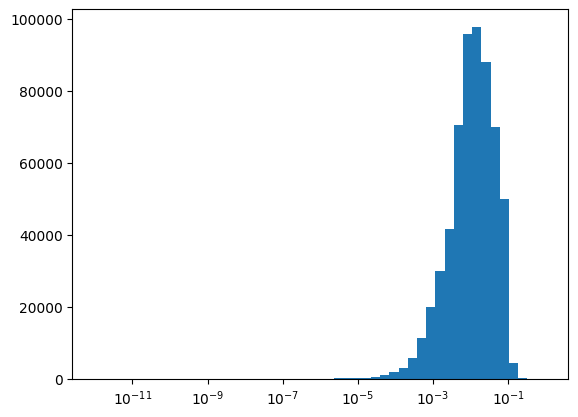

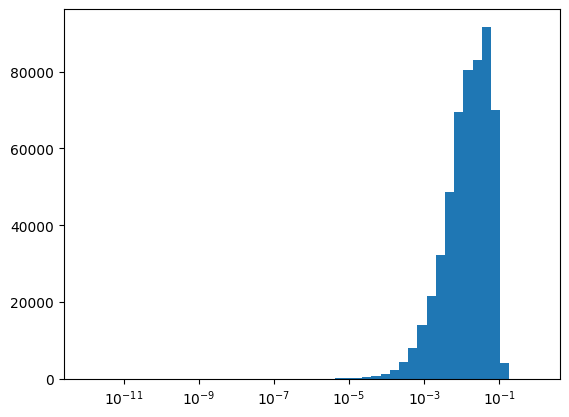

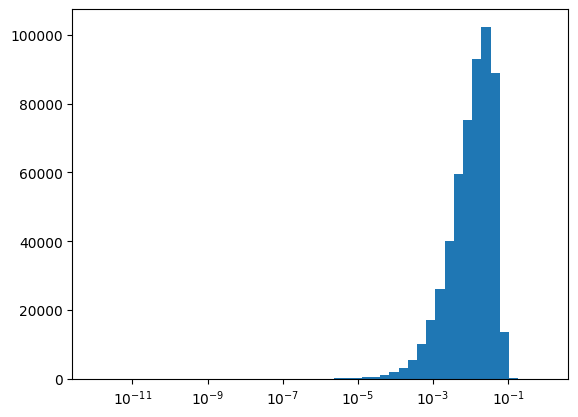

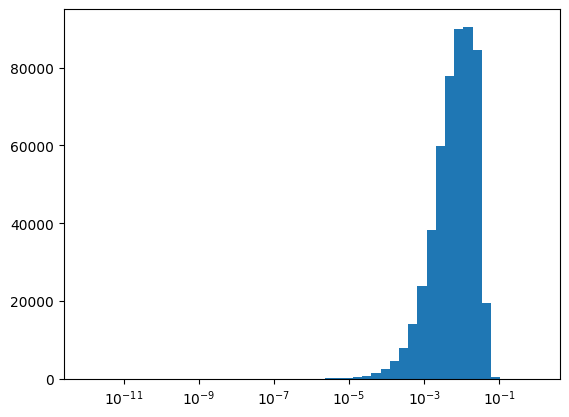

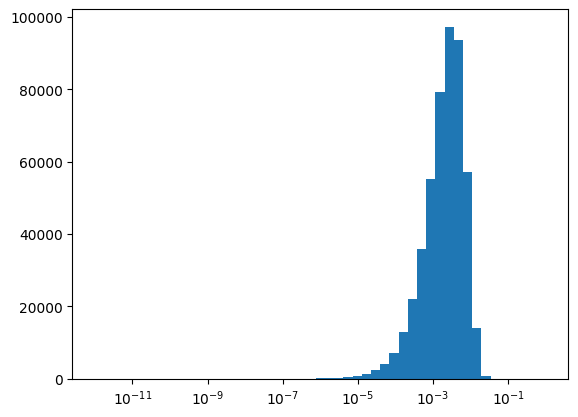

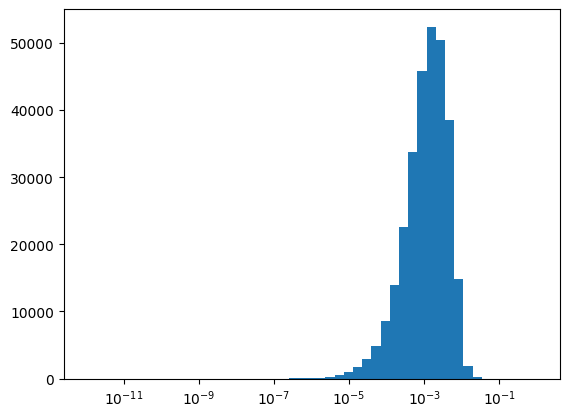

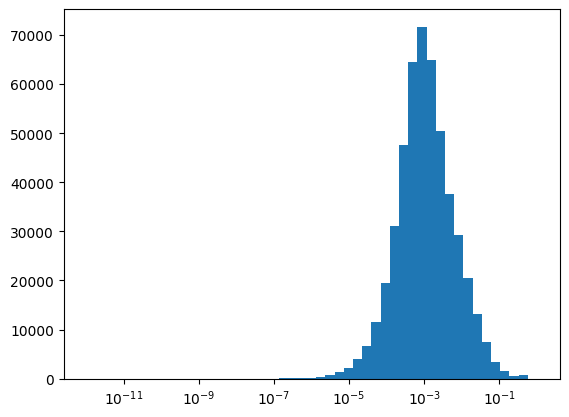

In [26]:
x= noisy_abs * snet.lmbda[0]

for block in snet.blocks_normed:
    x = block(x)

    if isinstance(block,torch.nn.ReLU):
        print(torch.min(x[x.nonzero(as_tuple=True)]),torch.max(x))
        plt.figure()
        hiost, bins, _ = plt.hist(x.numpy().flatten(),range=(0,1),bins=np.logspace(-12,0))
        plt.xscale('log')
        #print(bins)
        #logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        #ax.set_xscale('log')


In [27]:
torch.save(snet.state_dict(), 'chkpt_fullconv_normed.pt')